# Cogs 109: Modeling and Data Analysis
## Final project guidelines, 2019

Work in teams of at least 2 and no more than 4 students. Every student in the group will be expected to contribute substantially to the final product(s), and all students should be able to understand and explain all aspects of the project when you present your work in the final symposium.

Your project should. 
- Identify a real problem, challenge or scientific question which could benefit from data analysis and modeling. Your final report must explain why the question is interesting or important. 
- Identify a relevant data set. You should learn about how the data was collected and be able to explain key features of the data, for example: How many observations? What are the noise sources? What are the relevant predictors?
Identify at least one relevant data analysis approach, choosing from the methods covered in the course (linear or nonlinear regression, classification, clustering, PCA, etc.). Explain why this analysis approach is appropriate for addressing your question.
- Identify and explain one or more hypotheses or initial expectation that you will test using the data.
- Model selection: You should compare and contrast multiple different models (at least 2, but usually more). Your comparison should make use of cross-validation, bootstrap sampling, regularization, and/or other relevant techniques. For example, you might compare K-Nearest Neighbors classification for a range of k values (k=1,2,…,50), and select the k value that provides the lowest test set (cross-validation) error.
- Model estimation: Implement your data analysis and present the results using a combination of data visualizations (box plots, scatter plots), statistical analyses and models.
- Present your conclusions and outlook for next steps/future directions.

The final product will be a written report, 5-10 pages in length. In addition, you will create a poster explaining your project to be presented in a symposium session on the last day of class. We will provide more information about the final paper and poster in a few weeks.


## Written report:
Your final report must include the following sections (use these headings).
- Introduction. 
    - Define the real problem and explain its motivation
    - Identify the dataset you will use and explain its key characteristics.
    - Explain at least one hypothesis that you will test.
- Methods. Identify the data analysis approach you will use and explain the rationale/motivation for your choice of this approach.
- Results
    - Model selection. You MUST compare at least 2 models, using cross-validation, regularization, and/or other relevant techniques.
    - Model estimation. What are the final parameter estimates? What is the final accuracy of the model’s predictions?
    - Conclusions and discussion. What can you conclude about your hypothesis? (Note that negative or ambiguous results are perfectly acceptable, you just need to explain what you found.) What are some potential implications/next steps for researchers interested in this topic?


In [17]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler

In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [91]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            pytrends.build_payload([kw], cat=0, timeframe=dates, geo='', gprop='')
            df_temp = pytrends.interest_over_time()
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            if df.empty:
                df = df_temp
            else:
                df = df.join(df_temp)
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [98]:
# Get Stock Daily info for past 100 days
def getDailyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_DAILY'
        api_key = ''
        outputsize = 'compact'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
            r = requests.get(link)
            data = json.loads(r.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            if "Time Series (Daily)" not in data:
                break
            stock_data_per_day = json.dumps(data["Time Series (Daily)"])
            df_temp = pd.read_json(stock_data_per_day).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [95]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [131]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [123]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    mdl=sm.formula.ols(formula=formula, data=training_data).fit()
    return mdl

In [147]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train, df_all_data_test):
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 1000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    return bestAlpha, clf

In [148]:
#ridge regression

def trainAndPlotRidgeRegression(y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train, df_all_data_test)
    #     print("alpha: "+str(bestAlpha))
    #     print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    #     print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    #     print()

    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title('Stock Market Profits per Day from 3 months until today')
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()

In [149]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [150]:
# Get stock data
dict_stocks = getDailyStockInfoDict(company_symbol)

In [153]:
# Join data together, train various models
for company in companies[:1]: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    # Add profit column
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data = df_all_data.iloc[::-1] # Reverse index order
    
    # Trends cols (everything except these cols that are removed)
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    # print(cols)
    
    for col in cols[:1]: 
        col_increment = [df_all_data[col][i] - [df_all_data[col][i-1] for i in range(1, len(df_all_data))]]
        df_all_data[col+'_increment'] = col_increment
    
    print(col_increment)
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
                         
    # Profit prediction: 
    #profit_multiple_regression_mdl = trainMultipleRegression('profit', cols, df_all_data_train)
    
    # Stock price prediction
    #close_multiple_regression_mdl = trainMultipleRegression('close', cols, df_all_data_train)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    # Ridge Regression
    trainAndPlotRidgeRegression('close', cols, df_all_data_train, df_all_data_test)
    

tesla


NameError: name 'i' is not defined

## Tensorflow + Keras time

In [90]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [103]:
df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
df_all_data[cols+['mid']]

,facebook_report,facebook_good,facebook_bad,facebook_up,facebook_down,facebook_stock,mid
62,78,88,65,49,15,59,185.13010
61,85,87,70,46,14,52,183.89000
60,87,95,83,47,13,62,185.81970
59,78,90,83,49,15,61,189.65000
58,100,87,87,46,12,57,188.28000
...,...,...,...,...,...,...,...
4,76,98,80,45,11,64,197.97500
3,85,81,74,44,11,59,198.46000
2,73,86,75,44,12,55,200.11000
1,81,90,70,43,15,57,199.09435


In [104]:
#scale data to be between 0-1 
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_standardized_data[cols+['mid']])


In [105]:
# Get training and test set
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 6) (50,) (13, 1, 6) (13,)


In [106]:
# Create a sequential NN

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [107]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

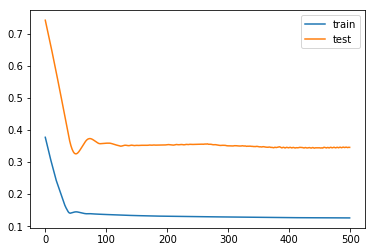

In [108]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

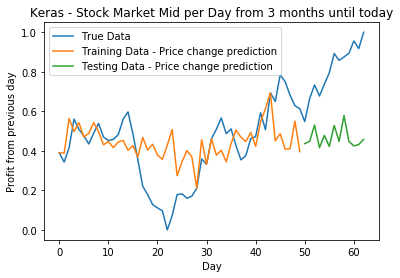

In [97]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('Keras - Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [38]:
df_stocks['microsoft']

,times,open,high,low,close,volume
0,2019-11-27,152.33,152.50,151.5200,152.32,15123806.0
1,2019-11-26,151.36,152.42,151.3200,152.03,24635100.0
2,2019-11-25,150.00,151.35,149.9200,151.23,22428585.0
3,2019-11-22,150.07,150.30,148.8200,149.59,15841680.0
4,2019-11-21,149.40,149.80,148.5010,149.48,18576083.0
...,...,...,...,...,...,...
95,2019-07-16,138.96,139.05,136.5200,137.08,22726128.0
96,2019-07-15,139.44,139.54,138.4600,138.90,16651457.0
97,2019-07-12,138.85,139.13,138.0099,138.90,18936832.0
98,2019-07-11,138.20,139.22,137.8700,138.40,22327942.0


In [39]:
df_msft = df_stocks['microsoft'][['high', 'low']].iloc[::-1]
df_msft['mid'] = (df_msft['high'] + df_msft['low']) /2

In [40]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[['high', 'low', 'mid']])

In [41]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 2) (50,) (50, 1, 2) (50,)


In [42]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [43]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 50 samples, validate on 50 samples
Epoch 1/500
 - 1s - loss: 0.2611 - val_loss: 0.5294
Epoch 2/500
 - 0s - loss: 0.2564 - val_loss: 0.5229
Epoch 3/500
 - 0s - loss: 0.2516 - val_loss: 0.5163
Epoch 4/500
 - 0s - loss: 0.2469 - val_loss: 0.5097
Epoch 5/500
 - 0s - loss: 0.2422 - val_loss: 0.5032
Epoch 6/500
 - 0s - loss: 0.2375 - val_loss: 0.4966
Epoch 7/500
 - 0s - loss: 0.2327 - val_loss: 0.4901
Epoch 8/500
 - 0s - loss: 0.2280 - val_loss: 0.4835
Epoch 9/500
 - 0s - loss: 0.2233 - val_loss: 0.4770
Epoch 10/500
 - 0s - loss: 0.2186 - val_loss: 0.4704
Epoch 11/500
 - 0s - loss: 0.2138 - val_loss: 0.4638
Epoch 12/500
 - 0s - loss: 0.2091 - val_loss: 0.4572
Epoch 13/500
 - 0s - loss: 0.2043 - val_loss: 0.4506
Epoch 14/500
 - 0s - loss: 0.1995 - val_loss: 0.4440
Epoch 15/500
 - 0s - loss: 0.1947 - val_loss: 0.4374
Epoch 16/500
 - 0s - loss: 0.1899 - val_loss: 0.4307
Epoch 17/500
 - 0s - loss: 0.1852 - val_loss: 0.4240
Epoch 18/500
 - 0s - loss: 0.1805 - val_loss: 0.4173
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0277 - val_loss: 0.0847
Epoch 155/500
 - 0s - loss: 0.0274 - val_loss: 0.0835
Epoch 156/500
 - 0s - loss: 0.0271 - val_loss: 0.0823
Epoch 157/500
 - 0s - loss: 0.0268 - val_loss: 0.0810
Epoch 158/500
 - 0s - loss: 0.0264 - val_loss: 0.0796
Epoch 159/500
 - 0s - loss: 0.0261 - val_loss: 0.0780
Epoch 160/500
 - 0s - loss: 0.0258 - val_loss: 0.0766
Epoch 161/500
 - 0s - loss: 0.0255 - val_loss: 0.0753
Epoch 162/500
 - 0s - loss: 0.0251 - val_loss: 0.0740
Epoch 163/500
 - 0s - loss: 0.0248 - val_loss: 0.0727
Epoch 164/500
 - 0s - loss: 0.0245 - val_loss: 0.0712
Epoch 165/500
 - 0s - loss: 0.0241 - val_loss: 0.0697
Epoch 166/500
 - 0s - loss: 0.0238 - val_loss: 0.0683
Epoch 167/500
 - 0s - loss: 0.0234 - val_loss: 0.0668
Epoch 168/500
 - 0s - loss: 0.0231 - val_loss: 0.0653
Epoch 169/500
 - 0s - loss: 0.0227 - val_loss: 0.0638
Epoch 170/500
 - 0s - loss: 0.0224 - val_loss: 0.0622
Epoch 171/500
 - 0s - loss: 0.0220 - val_loss: 0.0607
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0018 - val_loss: 0.0246
Epoch 307/500
 - 0s - loss: 0.0018 - val_loss: 0.0243
Epoch 308/500
 - 0s - loss: 0.0018 - val_loss: 0.0238
Epoch 309/500
 - 0s - loss: 0.0018 - val_loss: 0.0240
Epoch 310/500
 - 0s - loss: 0.0017 - val_loss: 0.0241
Epoch 311/500
 - 0s - loss: 0.0017 - val_loss: 0.0238
Epoch 312/500
 - 0s - loss: 0.0017 - val_loss: 0.0234
Epoch 313/500
 - 0s - loss: 0.0018 - val_loss: 0.0237
Epoch 314/500
 - 0s - loss: 0.0017 - val_loss: 0.0237
Epoch 315/500
 - 0s - loss: 0.0017 - val_loss: 0.0235
Epoch 316/500
 - 0s - loss: 0.0017 - val_loss: 0.0231
Epoch 317/500
 - 0s - loss: 0.0017 - val_loss: 0.0235
Epoch 318/500
 - 0s - loss: 0.0017 - val_loss: 0.0236
Epoch 319/500
 - 0s - loss: 0.0017 - val_loss: 0.0232
Epoch 320/500
 - 0s - loss: 0.0017 - val_loss: 0.0227
Epoch 321/500
 - 0s - loss: 0.0017 - val_loss: 0.0229
Epoch 322/500
 - 0s - loss: 0.0017 - val_loss: 0.0229
Epoch 323/500
 - 0s - loss: 0.0017 - val_loss: 0.0227
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0010 - val_loss: 0.0116
Epoch 459/500
 - 0s - loss: 0.0010 - val_loss: 0.0112
Epoch 460/500
 - 0s - loss: 9.9962e-04 - val_loss: 0.0110
Epoch 461/500
 - 0s - loss: 0.0010 - val_loss: 0.0115
Epoch 462/500
 - 0s - loss: 0.0010 - val_loss: 0.0114
Epoch 463/500
 - 0s - loss: 0.0010 - val_loss: 0.0108
Epoch 464/500
 - 0s - loss: 9.8267e-04 - val_loss: 0.0109
Epoch 465/500
 - 0s - loss: 9.6876e-04 - val_loss: 0.0107
Epoch 466/500
 - 0s - loss: 9.6132e-04 - val_loss: 0.0108
Epoch 467/500
 - 0s - loss: 9.5835e-04 - val_loss: 0.0106
Epoch 468/500
 - 0s - loss: 9.5579e-04 - val_loss: 0.0109
Epoch 469/500
 - 0s - loss: 9.6619e-04 - val_loss: 0.0108
Epoch 470/500
 - 0s - loss: 9.5835e-04 - val_loss: 0.0104
Epoch 471/500
 - 0s - loss: 9.4501e-04 - val_loss: 0.0107
Epoch 472/500
 - 0s - loss: 9.4716e-04 - val_loss: 0.0106
Epoch 473/500
 - 0s - loss: 9.3954e-04 - val_loss: 0.0101
Epoch 474/500
 - 0s - loss: 9.3352e-04 - val_loss: 0.0104
Epoch 475/500
 - 0s - loss: 9.2876

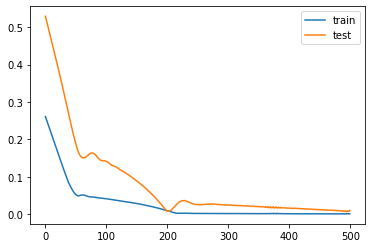

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

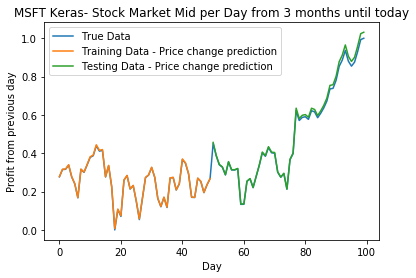

In [45]:
plt.plot(range(100) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, 100), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [46]:
msft_names = [x for x in list(df.columns.values) if 'microsoft' in x]
df_msft_trends = df[msft_names]
stock_times = df_stocks['microsoft'].times
trends_times = list(df_msft_trends.index)
joint_times = list(set(stock_times) & set(trends_times)) 
df_stocks['microsoft'] = df_stocks['microsoft'].loc[df_stocks['microsoft']['times'].isin(joint_times)]
df_stocks['microsoft'] = df_stocks['microsoft'].reset_index()
print(df_stocks['microsoft'].head())
df_msft_trends = df_msft_trends.loc[df_msft_trends.index.isin(joint_times)]
df_msft_trends = df_msft_trends.reset_index()
df_msft_trends.columns = ['_'.join(x.split()) for x in list(df_msft_trends.columns) if len(x) > 1]
print(df_msft_trends.head())
df_msft = df_msft_trends.join(df_stocks['microsoft'])
df_msft['profit'] = df_msft['open']-df_msft['close']
df_msft = df_msft.iloc[::-1]
df_msft.head()

   index      times    open    high      low   close      volume
0      2 2019-11-25  150.00  151.35  149.920  151.23  22428585.0
1      3 2019-11-22  150.07  150.30  148.820  149.59  15841680.0
2      4 2019-11-21  149.40  149.80  148.501  149.48  18576083.0
3      5 2019-11-20  150.31  150.84  148.460  149.62  25720060.0
4      6 2019-11-19  150.88  151.33  150.195  150.39  23960164.0
        date  microsoft_report  microsoft_good  microsoft_bad  microsoft_up  \
0 2019-11-25                39              71             47            80   
1 2019-11-22                47              65             54            90   
2 2019-11-21                59              78             83            80   
3 2019-11-20                50              71             58            96   
4 2019-11-19                64              92             43            74   

   microsoft_down  microsoft_stock  
0              31               54  
1              31               54  
2              36       

,date,microsoft_report,microsoft_good,microsoft_bad,microsoft_up,microsoft_down,microsoft_stock,index,times,open,high,low,close,volume,profit
62,2019-08-28,55,66,40,88,41,41,64,2019-08-28,134.88,135.76,133.55,135.56,17343042.0,-0.68
61,2019-08-29,52,68,49,81,21,43,63,2019-08-29,137.25,138.44,136.91,138.12,20179716.0,-0.87
60,2019-08-30,43,79,56,80,22,40,62,2019-08-30,139.15,139.18,136.27,137.86,23946123.0,1.29
59,2019-09-03,61,69,39,87,28,32,61,2019-09-03,136.61,137.20,135.70,136.04,18880773.0,0.57
58,2019-09-04,59,67,44,82,41,34,60,2019-09-04,137.30,137.69,136.48,137.63,18015310.0,-0.33


In [48]:
cols = ['microsoft_'+ x for x in key_terms]
df_msft['mid'] = (df_fb['high'] + df_fb['low'])/2
df_msft[cols+['high', 'low']+['mid']]

,microsoft_report,microsoft_good,microsoft_bad,microsoft_up,microsoft_down,microsoft_stock,high,low,mid
62,55,66,40,88,41,41,135.76,133.550,180.4350
61,52,68,49,81,21,43,138.44,136.910,184.7726
60,43,79,56,80,22,40,139.18,136.270,185.1301
59,61,69,39,87,28,32,137.20,135.700,183.8900
58,59,67,44,82,41,34,137.69,136.480,185.8197
...,...,...,...,...,...,...,...,...,...
4,64,92,43,74,35,66,151.33,150.195,198.4300
3,50,71,58,96,88,67,150.84,148.460,197.5100
2,59,78,83,80,36,54,149.80,148.501,197.9750
1,47,65,54,90,31,54,150.30,148.820,198.4600


In [49]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[cols+['high', 'low', 'mid']])

In [50]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 8) (50,) (13, 1, 8) (13,)


In [51]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [52]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 50 samples, validate on 13 samples
Epoch 1/500
 - 1s - loss: 0.4987 - val_loss: 0.9215
Epoch 2/500
 - 0s - loss: 0.4872 - val_loss: 0.9068
Epoch 3/500
 - 0s - loss: 0.4758 - val_loss: 0.8920
Epoch 4/500
 - 0s - loss: 0.4644 - val_loss: 0.8774
Epoch 5/500
 - 0s - loss: 0.4530 - val_loss: 0.8627
Epoch 6/500
 - 0s - loss: 0.4417 - val_loss: 0.8481
Epoch 7/500
 - 0s - loss: 0.4308 - val_loss: 0.8335
Epoch 8/500
 - 0s - loss: 0.4199 - val_loss: 0.8189
Epoch 9/500
 - 0s - loss: 0.4091 - val_loss: 0.8043
Epoch 10/500
 - 0s - loss: 0.3983 - val_loss: 0.7897
Epoch 11/500
 - 0s - loss: 0.3874 - val_loss: 0.7751
Epoch 12/500
 - 0s - loss: 0.3766 - val_loss: 0.7605
Epoch 13/500
 - 0s - loss: 0.3662 - val_loss: 0.7458
Epoch 14/500
 - 0s - loss: 0.3559 - val_loss: 0.7312
Epoch 15/500
 - 0s - loss: 0.3455 - val_loss: 0.7165
Epoch 16/500
 - 0s - loss: 0.3352 - val_loss: 0.7017
Epoch 17/500
 - 0s - loss: 0.3252 - val_loss: 0.6870
Epoch 18/500
 - 0s - loss: 0.3157 - val_loss: 0.6720
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.1251 - val_loss: 0.0674
Epoch 155/500
 - 0s - loss: 0.1248 - val_loss: 0.0675
Epoch 156/500
 - 0s - loss: 0.1246 - val_loss: 0.0675
Epoch 157/500
 - 0s - loss: 0.1243 - val_loss: 0.0674
Epoch 158/500
 - 0s - loss: 0.1241 - val_loss: 0.0674
Epoch 159/500
 - 0s - loss: 0.1238 - val_loss: 0.0673
Epoch 160/500
 - 0s - loss: 0.1235 - val_loss: 0.0672
Epoch 161/500
 - 0s - loss: 0.1232 - val_loss: 0.0671
Epoch 162/500
 - 0s - loss: 0.1230 - val_loss: 0.0670
Epoch 163/500
 - 0s - loss: 0.1227 - val_loss: 0.0670
Epoch 164/500
 - 0s - loss: 0.1225 - val_loss: 0.0670
Epoch 165/500
 - 0s - loss: 0.1222 - val_loss: 0.0673
Epoch 166/500
 - 0s - loss: 0.1220 - val_loss: 0.0679
Epoch 167/500
 - 0s - loss: 0.1217 - val_loss: 0.0687
Epoch 168/500
 - 0s - loss: 0.1214 - val_loss: 0.0697
Epoch 169/500
 - 0s - loss: 0.1211 - val_loss: 0.0708
Epoch 170/500
 - 0s - loss: 0.1208 - val_loss: 0.0721
Epoch 171/500
 - 0s - loss: 0.1206 - val_loss: 0.0731
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0994 - val_loss: 0.2276
Epoch 307/500
 - 0s - loss: 0.0994 - val_loss: 0.2289
Epoch 308/500
 - 0s - loss: 0.0993 - val_loss: 0.2306
Epoch 309/500
 - 0s - loss: 0.0993 - val_loss: 0.2298
Epoch 310/500
 - 0s - loss: 0.0992 - val_loss: 0.2283
Epoch 311/500
 - 0s - loss: 0.0992 - val_loss: 0.2294
Epoch 312/500
 - 0s - loss: 0.0991 - val_loss: 0.2296
Epoch 313/500
 - 0s - loss: 0.0990 - val_loss: 0.2290
Epoch 314/500
 - 0s - loss: 0.0990 - val_loss: 0.2296
Epoch 315/500
 - 0s - loss: 0.0990 - val_loss: 0.2279
Epoch 316/500
 - 0s - loss: 0.0990 - val_loss: 0.2297
Epoch 317/500
 - 0s - loss: 0.0990 - val_loss: 0.2284
Epoch 318/500
 - 0s - loss: 0.0989 - val_loss: 0.2279
Epoch 319/500
 - 0s - loss: 0.0989 - val_loss: 0.2307
Epoch 320/500
 - 0s - loss: 0.0989 - val_loss: 0.2293
Epoch 321/500
 - 0s - loss: 0.0988 - val_loss: 0.2289
Epoch 322/500
 - 0s - loss: 0.0988 - val_loss: 0.2308
Epoch 323/500
 - 0s - loss: 0.0989 - val_loss: 0.2304
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0968 - val_loss: 0.2437
Epoch 459/500
 - 0s - loss: 0.0970 - val_loss: 0.2447
Epoch 460/500
 - 0s - loss: 0.0968 - val_loss: 0.2487
Epoch 461/500
 - 0s - loss: 0.0964 - val_loss: 0.2547
Epoch 462/500
 - 0s - loss: 0.0970 - val_loss: 0.2544
Epoch 463/500
 - 0s - loss: 0.0969 - val_loss: 0.2485
Epoch 464/500
 - 0s - loss: 0.0964 - val_loss: 0.2455
Epoch 465/500
 - 0s - loss: 0.0967 - val_loss: 0.2459
Epoch 466/500
 - 0s - loss: 0.0967 - val_loss: 0.2491
Epoch 467/500
 - 0s - loss: 0.0964 - val_loss: 0.2551
Epoch 468/500
 - 0s - loss: 0.0967 - val_loss: 0.2555
Epoch 469/500
 - 0s - loss: 0.0967 - val_loss: 0.2509
Epoch 470/500
 - 0s - loss: 0.0963 - val_loss: 0.2482
Epoch 471/500
 - 0s - loss: 0.0966 - val_loss: 0.2487
Epoch 472/500
 - 0s - loss: 0.0965 - val_loss: 0.2522
Epoch 473/500
 - 0s - loss: 0.0962 - val_loss: 0.2571
Epoch 474/500
 - 0s - loss: 0.0966 - val_loss: 0.2572
Epoch 475/500
 - 0s - loss: 0.0966 - val_loss: 0.2530
Epoch 476/500
 - 0s - loss: 

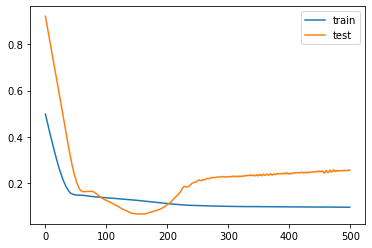

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

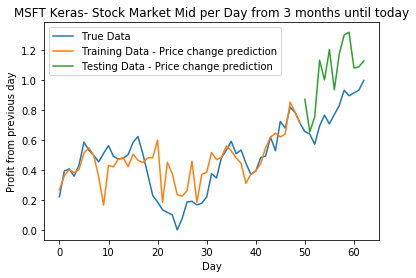

In [55]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()